# ****Importing Important Libraries****

In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [4]:
df=pd.read_csv('/content/NEW_TATAMOTORS__EQ__NSE__NSE__MINUTE.csv')

In [5]:
df.shape


(150000, 6)

In [6]:
df.head()


,timestamp,open,high,low,close,volume
0,2017-01-02 09:15:00+05:30,472.0,473.0,471.35,472.00,28096
1,2017-01-02 09:16:00+05:30,472.0,473.0,472.00,472.85,16635
2,2017-01-02 09:17:00+05:30,472.6,473.0,470.95,470.95,13810
3,2017-01-02 09:18:00+05:30,471.0,471.7,470.50,471.50,13836
4,2017-01-02 09:19:00+05:30,471.5,473.3,471.50,473.00,19115


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)


In [8]:
df.sort_index(inplace=True)

Null values

In [9]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [10]:
df.fillna(method='ffill', inplace=True)

In [11]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [12]:
df.head(10)

,open,high,low,close,volume
timestamp,,,,,
2017-01-02 09:15:00+05:30,472.0,473.00,471.35,472.00,28096
2017-01-02 09:16:00+05:30,472.0,473.00,472.00,472.85,16635
2017-01-02 09:17:00+05:30,472.6,473.00,470.95,470.95,13810
2017-01-02 09:18:00+05:30,471.0,471.70,470.50,471.50,13836
2017-01-02 09:19:00+05:30,471.5,473.30,471.50,473.00,19115
2017-01-02 09:20:00+05:30,473.0,473.00,471.50,471.95,16828
2017-01-02 09:21:00+05:30,472.0,472.60,471.85,472.05,14242
2017-01-02 09:22:00+05:30,472.0,472.15,471.10,471.85,12905
2017-01-02 09:23:00+05:30,471.6,472.00,471.25,471.40,11795


# Ploting Close Price History using matplotlib

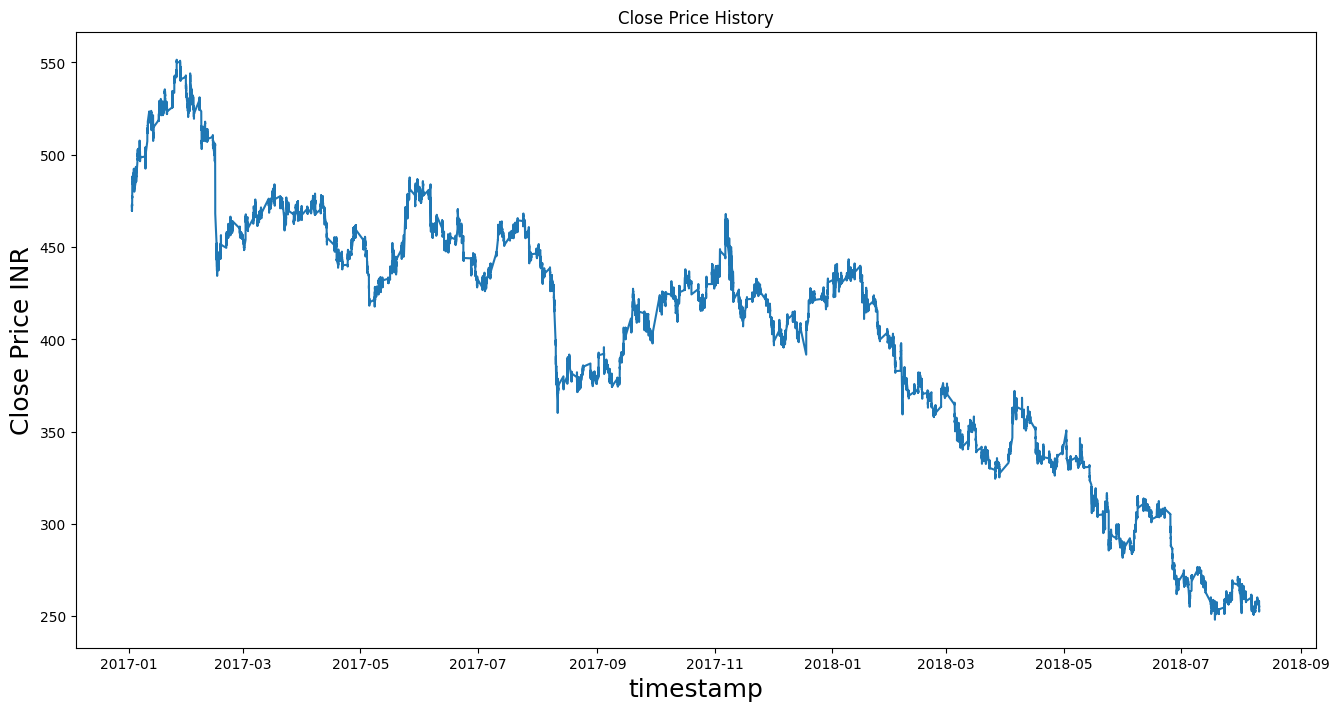

In [13]:
import seaborn as sns
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['close'])
#ax=sns.lineplot(data=df, x='timestamp',y='close', color="blue");
plt.xlabel('timestamp',fontsize=18)
plt.ylabel('Close Price INR',fontsize=18)
plt.show()

# Converting data to a numpy array

In [73]:
df.shape


(150000, 2)

In [15]:
data = df.filter(['close'])
dataset = data.values
training_data_len = math.ceil( len(dataset) *.8)
print('training_data_len=',training_data_len)
len(dataset)

training_data_len= 120000


150000

In [16]:
dataset

array([[472.  ],
       [472.85],
       [470.95],
       ...,
       [253.1 ],
       [253.3 ],
       [253.35]])

# Transforming the dataset array to range between 0 and 1

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [18]:
train_data = scaled_data[0:training_data_len  , : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

#Train and test split

In [19]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [21]:
len(x_train)

119940

# **Building a LSTM Model for Stock Market Prediction**

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# **Using adam optimizer and mean_squared_error as the loss function**

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model.fit(x_train, y_train, batch_size=64, epochs=1)

1875/1875 [==============================] - 109s 56ms/step - loss: 4.3533e-04


In [25]:
test_data = scaled_data[training_data_len - 60: , : ]#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])


In [26]:
x_test = np.array(x_test)

In [27]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [28]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

938/938 [==============================] - 16s 17ms/step


# Evaluate

In [29]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

3.9487859880043126

# **Plotting the predicted values**

<ipython-input-30-d1d3e758b1fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display['Predictions'] = predictions#Visualize the data


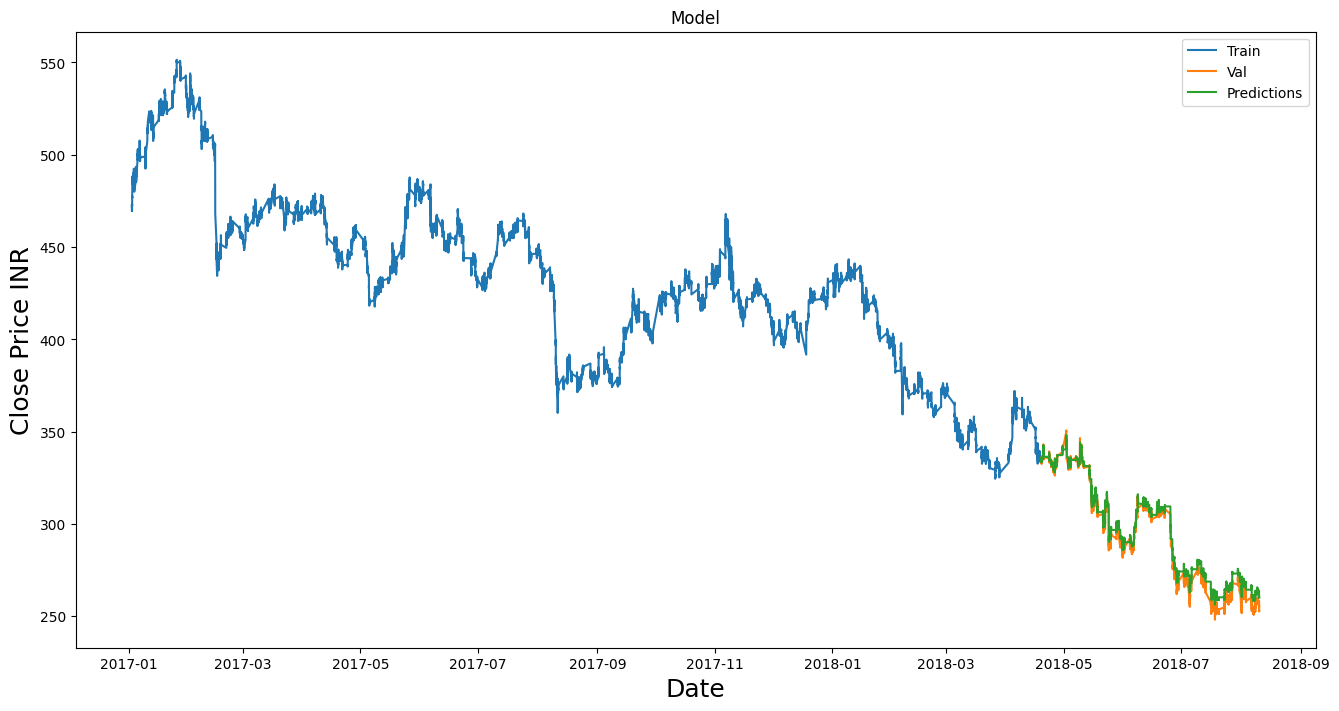

In [30]:
train = data[:training_data_len]
display = data[training_data_len:]
display['Predictions'] = predictions#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.plot(train['close'])
plt.plot(display['close'])
plt.plot(display['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

#It is clear from the graph, the model predicted the close price quiet accurately

#Applying Arima

In [31]:
df=pd.read_csv('/content/NEW_TATAMOTORS__EQ__NSE__NSE__MINUTE.csv')

In [32]:
df = df.filter(['timestamp','close'])

In [33]:
df.head()

,timestamp,close
0,2017-01-02 09:15:00+05:30,472.00
1,2017-01-02 09:16:00+05:30,472.85
2,2017-01-02 09:17:00+05:30,470.95
3,2017-01-02 09:18:00+05:30,471.50
4,2017-01-02 09:19:00+05:30,473.00


In [35]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [36]:
df.head()

,timestamp,close
0,2017-01-02 09:15:00+05:30,472.00
1,2017-01-02 09:16:00+05:30,472.85
2,2017-01-02 09:17:00+05:30,470.95
3,2017-01-02 09:18:00+05:30,471.50
4,2017-01-02 09:19:00+05:30,473.00


In [37]:
df.set_index('timestamp',inplace=True)

In [38]:
df.head()

,close
timestamp,
2017-01-02 09:15:00+05:30,472.00
2017-01-02 09:16:00+05:30,472.85
2017-01-02 09:17:00+05:30,470.95
2017-01-02 09:18:00+05:30,471.50
2017-01-02 09:19:00+05:30,473.00


#Stationarity Check


In [39]:
test_result=adfuller(df['close'])

In [40]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(close):
    result=adfuller(close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [41]:
adfuller_test(df['close'])

ADF Test Statistic : -0.19023889638097854
p-value : 0.939675157441569
#Lags Used : 22
Number of Observations Used : 149977
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#Differencing

In [42]:
df['Close First Difference'] = df['close'] - df['close'].shift(1)

In [43]:
df['Close First Difference'].head()

timestamp
2017-01-02 09:15:00+05:30     NaN
2017-01-02 09:16:00+05:30    0.85
2017-01-02 09:17:00+05:30   -1.90
2017-01-02 09:18:00+05:30    0.55
2017-01-02 09:19:00+05:30    1.50
Name: Close First Difference, dtype: float64

In [44]:
## Again test (augmented dickey) fuller test
adfuller_test(df['Close First Difference'].dropna())

ADF Test Statistic : -81.46282446721897
p-value : 0.0
#Lags Used : 21
Number of Observations Used : 149977
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='timestamp'>

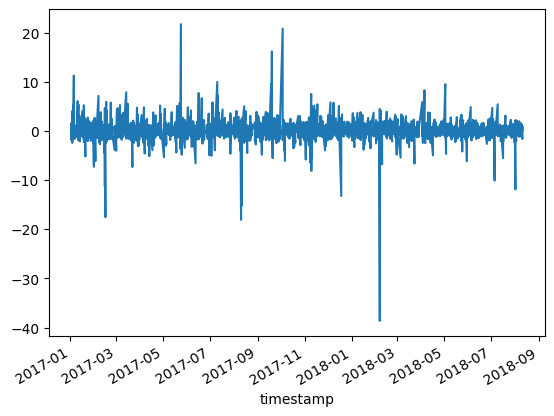

In [45]:
df['Close First Difference'].plot()

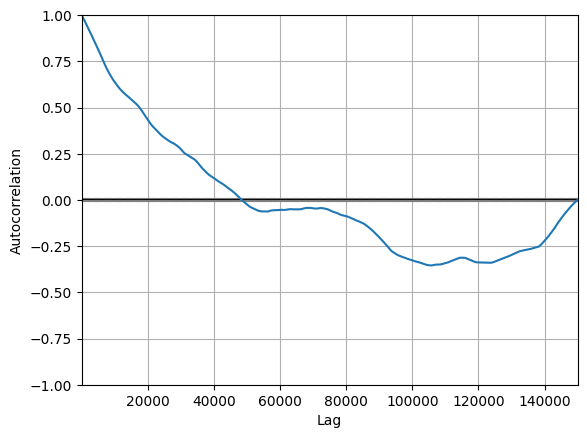

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['close'])
plt.show()


In [47]:
# Step 8: Model Validation and Evaluation
# Split the data into training and testing/validation sets
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [48]:
test_size = int(0.1 * df.shape[0])
train, test = train_test_split(df['close'],test_size = test_size)

In [49]:
train.shape, test.shape

((135000,), (15000,))

In [50]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [51]:
import statsmodels.api as sm

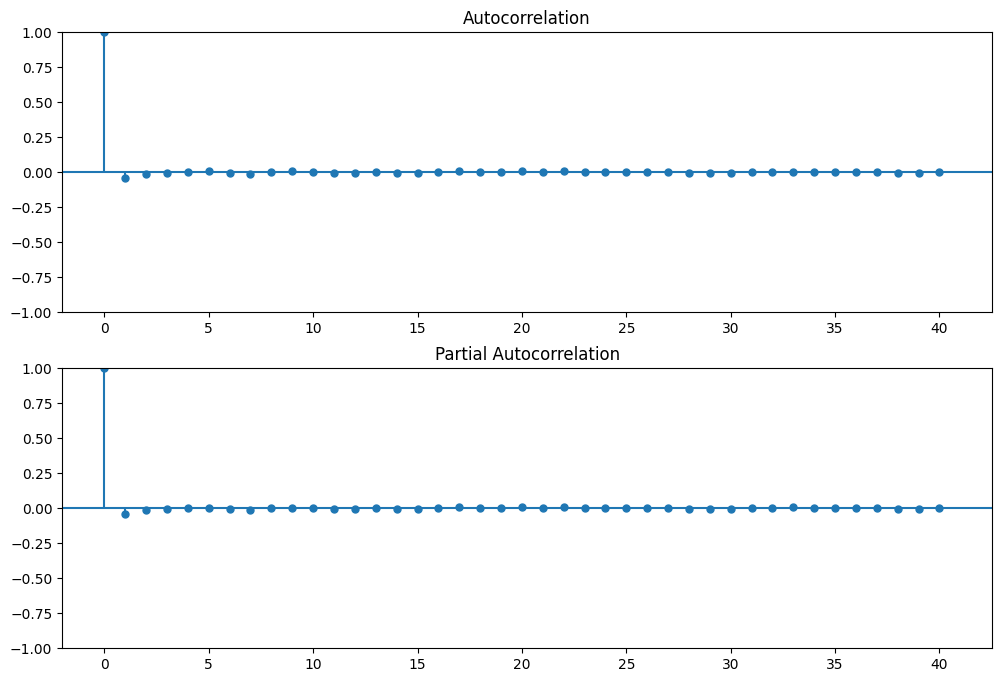

In [52]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Close First Difference'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Close First Difference'].iloc[1:],lags=40,ax=ax2)

In [53]:
# For non-seasonal data
#p=1....pacf, d=1, q=0 or 1....acf

import statsmodels.api as sm


In [55]:
model = pm.ARIMA((1,1,1))
model_fit = model.fit(train)

#model = sm.tsa.arima.ARIMA(train, order=(1, 1, 1))
#model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [63]:
# Make predictions on the test set
predictions = model.predict(n_periods = test.shape[0])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [64]:
test.shape, predictions.shape

((15000,), (15000,))

#Evaluate

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [66]:
mean_absolute_error(test, predictions)

26.465759199731597

In [67]:
mse = mean_squared_error(test, predictions)
mse

836.2062811043588

In [68]:
rmse = mse**0.5
rmse

28.9172315601677

In [1]:
# Plot actual, predicted, and forecasted values
plt.plot(df.index, df['close'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

NameError: ignored